In [184]:
# Install required packages.
!conda install pyg -c pyg -c conda-forge
#pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
#!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.5.html
#!pip install torch-geometric
#!pip install -q git+https://github.com/snap-stanford/deepsnap.git
#!pip install -U -q PyDrive

Retrieving notices: ...working... done
- 

In [281]:
!pip install -q kaggle

In [284]:
!kaggle datasets list

Traceback (most recent call last):
  File "/Users/zacpangan/opt/anaconda3/envs/lightgcn/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/zacpangan/opt/anaconda3/envs/lightgcn/lib/python3.8/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/Users/zacpangan/opt/anaconda3/envs/lightgcn/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/zacpangan/.kaggle. Or use the environment method.


In [282]:
!kaggle competitions download -c Yelp2018

Traceback (most recent call last):
  File "/Users/zacpangan/opt/anaconda3/envs/lightgcn/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/zacpangan/opt/anaconda3/envs/lightgcn/lib/python3.8/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/Users/zacpangan/opt/anaconda3/envs/lightgcn/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/zacpangan/.kaggle. Or use the environment method.


# Implementing a Recommender System using LightGCN

In this colab, we explain how to set up a graph recommender system using the [LighGCN](https://arxiv.org/abs/2002.02126) model. Specifically, we apply LightGCN to a movie recommendation task using [PyTorch](https://pytorch.org/) and [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/).

We use the [MovieLens](https://grouplens.org/datasets/movielens/) (*small*) dataset which has 100,000 ratings applied to 9,000 movies by 600 users.

Our implementation was inspired by the following documentation and repositories:
- https://github.com/gusye1234/LightGCN-PyTorch
- https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch
- https://pytorch-geometric.readthedocs.io/en/latest/notes/load_csv.html

In [1]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# Loading the Dataset

We load the dataset and set ratings >=4 on a 0.5 ~ 5 scale as an edge between users and movies.

We split the edges of the graph using a 80/10/10 train/validation/test split.

In [2]:
business_path = './data/archive/yelp_academic_dataset_business.json'
rating_path = './data/archive/yelp_academic_dataset_review.json'

In [13]:
# load user and business nodes
def load_node_json(path, feature_name):
    """Loads csv containing node information

    Args:
        path (str): path to csv file
        index_col (str): column name of index column

    Returns:
        dict: mapping of csv row to node id
    """
    with open(path, 'r') as file:
        lines = file.readlines()
        data = [json.loads(line)[feature_name] for line in lines]
    df = pd.DataFrame(data)
    mapping = {index: i for i, index in enumerate(df.iloc[:, 0].unique())}
    return mapping

#test_mapping, test_df= load_node_json(rating_path)
user_mapping = load_node_json(rating_path, 'user_id')
business_mapping = load_node_json(business_path, 'business_id')

In [4]:
with open(rating_path, 'r') as file:
        lines = file.readlines()
        data = [json.loads(line)['user_id'] for line in lines]
df = pd.DataFrame(data)

In [8]:
df 

,0
0,mh_-eMZ6K5RLWhZyISBhwA
1,OyoGAe7OKpv6SyGZT5g77Q
2,8g_iMtfSiwikVnbP2etR0A
3,_7bHUi9Uuf5__HHc_Q8guQ
4,bcjbaE6dDog4jkNY91ncLQ
...,...
6990275,qskILQ3k0I_qcCMI-k6_QQ
6990276,Zo0th2m8Ez4gLSbHftiQvg
6990277,mm6E4FbCMwJmb7kPDZ5v2Q
6990278,YwAMC-jvZ1fvEUum6QkEkw


In [11]:
mapping = {index: i for i, index in enumerate(df.iloc[:, 0].unique())}

In [17]:
user_mapping

{'mh_-eMZ6K5RLWhZyISBhwA': 0,
 'OyoGAe7OKpv6SyGZT5g77Q': 1,
 '8g_iMtfSiwikVnbP2etR0A': 2,
 '_7bHUi9Uuf5__HHc_Q8guQ': 3,
 'bcjbaE6dDog4jkNY91ncLQ': 4,
 'eUta8W_HdHMXPzLBBZhL1A': 5,
 'r3zeYsv1XFBRA4dJpL78cw': 6,
 'yfFzsLmaWF2d4Sr0UNbBgg': 7,
 'wSTuiTk-sKNdcFyprzZAjg': 8,
 '59MxRhNVhU9MYndMkz0wtw': 9,
 '1WHRWwQmZOZDAhp2Qyny4g': 10,
 'ZbqSHbgCjzVAqaa7NKWn5A': 11,
 '9OAtfnWag-ajVxRbUTGIyg': 12,
 'smOvOajNG0lS4Pq7d8g4JQ': 13,
 '4Uh27DgGzsp6PqrH913giQ': 14,
 '1C2lxzUo1Hyye4RFIXly3g': 15,
 'Dd1jQj7S-BFGqRbApFzCFw': 16,
 'j2wlzrntrbKwyOcOiB3l3w': 17,
 'NDZvyYHTUWWu-kqgQzzDGQ': 18,
 'IQsF3Rc6IgCzjVV9DE8KXg': 19,
 'Ohhrhu1RkqfVciIVx_W5HQ': 20,
 'WBpQDAZymU0dhIqXcACGNw': 21,
 'vrKkXsozqqecF3CW4cGaVQ': 22,
 'OhECKhQEexFypOMY6kypRw': 23,
 'RreNy--tOmXMl1en0wiBOg': 24,
 'zoBajEyVA0z4IjbFsMJksg': 25,
 'clWLI5OZP2ad25ugMVI8gg': 26,
 'xVKE_HJ2pwUtTdLbL3pnCg': 27,
 'mNsVyC9tQVYtzLOCbh2Piw': 28,
 '-sryo4gDYxbZ1T5Bz4l5Bw': 29,
 'Jha0USGDMefGFRLik_xFQg': 30,
 '4hBhtCSgoxkrFgHa4YAD-w': 31,
 'QzCEzH3R7Z6erOGL

In [15]:
# load edges between users and movies
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    with open(path, 'r') as file:
        lines = file.readlines()
        data = [json.loads(line) for line in lines]
    df = pd.DataFrame(data)
    edge_index = None
    try:
        src = [src_mapping[index] for index in df[src_index_col]]
        dst = [dst_mapping[index] for index in df[dst_index_col]]
   
        edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


        edge_index = [[], []]
   
        for i in range(edge_attr.shape[0]):
            if edge_attr[i]:
                edge_index[0].append(src[i])
                edge_index[1].append(dst[i])
    except KeyError as e:
        # Handle the KeyError
        print(f"KeyError encountered: {e}. Key not found.")

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    rating_path,
    src_index_col='user_id',
    src_mapping=user_mapping,
    dst_index_col='business_id',
    dst_mapping=business_mapping,
    link_index_col='stars',
    rating_threshold=4)

In [39]:
edge_index.shape[1]

4684545

In [18]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_users, num_business = len(user_mapping), len(business_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [19]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_business, num_users + num_business))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_business, num_users + num_business))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_business, num_users + num_business))

In [20]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

## Matrix Form
In our implementation, we utilize the matrix form of LightGCN. We perform multi-scale diffusion to obtain the final embedding, which sums embeddings diffused across multi-hop scales.

\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the dimension of each embedding respectively

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix



In [21]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_users, num_businesses)

# Loss Function



We utilize a Bayesian Personalized Ranking (BPR) loss, a pairwise objective which encourages the predictions of positive samples to be higher than negative samples for each user.

\begin{equation}
L_{BPR} = -\sum_{u = 1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln{\sigma(\hat{y}_{ui} - \hat{y}_{uj})} + \lambda ||E^{(0)}||^2
\end{equation}

$\hat{y}_{u}$: predicted score of a positive sample

$\hat{y}_{uj}$: predicted score of a negative sample

$\lambda$: hyperparameter which controls the L2 regularization strength

In [22]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

# Evaluation Metrics

We evalaluate our model using the following metrics

\begin{equation}
\text{Recall} = \frac{TP}{TP + FP}
\end{equation}

\begin{equation}
\text{Precision} = \frac{TP}{TP + FN}
\end{equation}

**Dicounted Cumulative Gain (DCG)** at rank position p is defined as:

\begin{equation}
\text{DCG}_\text{p} = \sum_{i = 1}^p \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

p: a particular rank position

$rel_i \in \{0, 1\}$ : graded relevance of the result at position $i$

**Idealised Dicounted Cumulative Gain (IDCG)**, namely the maximum possible DCG, at rank position $p$ is defined as:

\begin{equation}
\text{IDCG}_\text{p} = \sum_{i = 1}^{|REL_p|} \frac{2^{rel_i} - 1}{\log_2{(i + 1)}}
\end{equation}

$|REL_p|$ : list of items ordered by their relevance up to position p

**Normalized Dicounted Cumulative Gain (NDCG)** at rank position $p$ is defined as:

\begin{equation}
\text{nDCG}_\text{p} = \frac{\text{DCG}_p}{\text{nDCG}_p}
\end{equation}

Specifically, we use the metrics recall@K, precision@K, and NDCG@K. @K indicates that these metrics are computed on the top K recommendations.

In [23]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [24]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [25]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [26]:
def Compute_Item_Distribution(top_K_items):
    """
    Compute D from the top-k recommended items for each user.
    
    Parameters:
    top_K_items(list): list of lists containing highly rated items of each user
    
    Returns:
    dict: D dictionary where keys are items and values are the number of users for whom the item has been recommended.
    """
    # Initialize dictionary to store item counts
    D = {}
    
    # Iterate through each user and their recommended items
    for items in top_K_items:
        for item in items:
            if item not in D:
                D[item] = 0
            D[item] += 1
    
    return D


In [28]:
def Compute_SRDP_Prob(top_K_items, k):
    """
    Compute P_i(u) and P_i(U) from the top-k recommended items for each user.
    
    Parameters:
    top_K_items(list): list of lists containing highly rated items of each user
    
    Returns:
    dict: P_u dictionary where keys are (user, item) pairs and values are the probabilities P_i(u).
    dict: P_U dictionary where keys are items and values are the probabilities P_i(U).
    """
    # Initialize dictionaries to store probabilities
    P_u = {}
    P_U = {}
    item_counts = Compute_Item_Distribution(top_K_items)
    
    # Total number of users
    total_users = len(top_K_items)
   
    try:# Compute P_i(u)
        for user in range(total_users):
            items = top_K_items[user]
            nrec = min(len(items), k)
            for item in items:
                P_u[(user, item)] = 1 / nrec
    except KeyError as e:
        # Handle the KeyError
        print(f"KeyError encountered: {e}. Key not found.")
 
    
    # Compute P_i(U)
    for item, count in item_counts.items():
        P_U[item] = count / total_users
    
    return P_u, P_U


In [29]:
def SRDPNovatK(top_K_items, k):
    
    P_u, P_U = Compute_SRDP_Prob(top_K_items, k)
    D = Compute_Item_Distribution(top_K_items)
    total_users = len(top_K_items)
    serendipity_sum = 0
    novelty_sum = 0
    
    for u in range(len(top_K_items)):
            user_serendipity = 0
            recommended_items = top_K_items[u]
            nrec = min(len(recommended_items), k)
            
            for i in recommended_items:
                Pi_u = P_u.get((u, i), 0)
                Pi_U = P_U.get(i, 0)
                user_serendipity += max(Pi_u - Pi_U, 0)
                
            serendipity_sum += (1 / nrec) * user_serendipity
            
            user_novelty = 0
            for i in recommended_items:
                D_i = D.get(i, 0)
                novelty_score = -np.log2(D_i / total_users) / nrec
                user_novelty += novelty_score
                
            novelty_sum += user_novelty
    
    serendipity_score = (1 / total_users) * serendipity_sum
    novelty_score = novelty_sum / total_users
    
    return serendipity_score, novelty_score


In [280]:
SRDPNovatK(top_K_items.tolist(),20)

(0.00015829078204783654, 0.03489505839500232)

In [30]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)
    srdp, nov = SRDPNovatK(top_K_items.tolist(), k)

    return recall, precision, ndcg, srdp, nov

In [31]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg, srdp, nov = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg, srdp, nov

# Training

Your test set performance should be in line with the following (*K=20*):

*Recall@K: 0.13, Precision@K: 0.045, NDCG@K: 0.10*

In [32]:
# define contants
ITERATIONS = 3000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 50
ITERS_PER_LR_DECAY = 50
K = 20
LAMBDA = 1e-6

In [33]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu.


In [44]:
# training loop
train_losses = []
val_losses = []
val_precision = []
val_recall = []
val_ndcg = []
val_srdp = []
val_nov = []


for iter in range(ITERATIONS):
 # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg, srdp, nov = evaluation(
                model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)

        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}, val_srdp@{K}: {round(srdp, 5)}, val_nov@{K}: {round(nov, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        val_precision.append(precision)
        val_recall.append(recall)
        val_ndcg.append(ndcg)
        val_srdp.append(srdp)
        val_nov .append(nov)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

IndexError: index 240978 is out of bounds for dimension 0 with size 150346

In [41]:
items_emb_final.shape

torch.Size([150346, 64])

In [43]:
neg_item_indices

tensor([ 716767,  211827,  369910,  ...,  703052,  364796, 1026035])

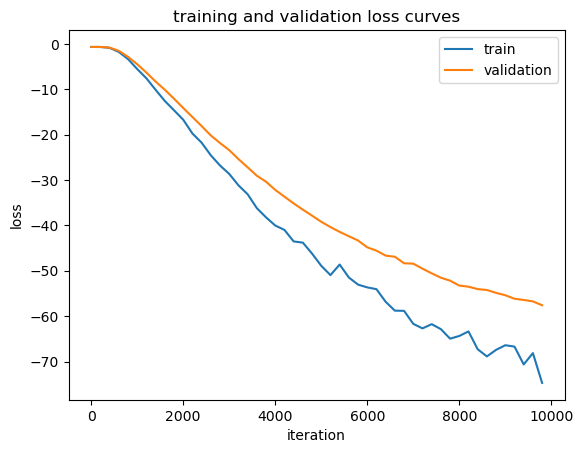

In [144]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

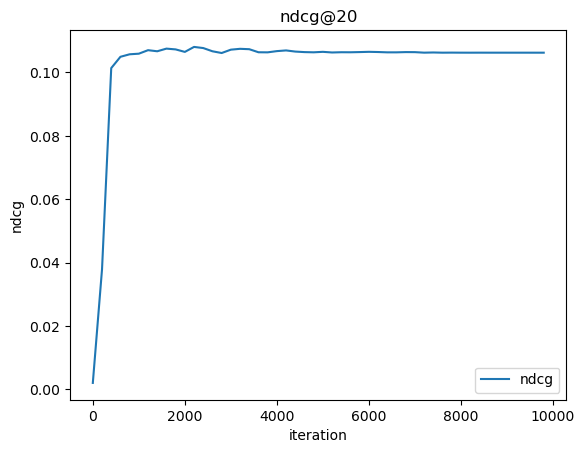

In [145]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(val_ndcg))]
plt.plot(iters, val_ndcg, label='ndcg')
plt.xlabel('iteration')
plt.ylabel('ndcg')
plt.title('ndcg@20')
plt.legend()
plt.show()

In [35]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg, test_srdp, test_nov = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)} test_srdp@{K}: {round(test_srdp, 5)}, test_nov@{K}: {round(test_nov, 5)}")

IndexError: index 1684357 is out of bounds for dimension 0 with size 150346

In [112]:
train_edge_index

tensor([[ 605,  110,  442,  ...,   65,  161,  427],
        [1111, 9637, 1284,  ..., 4648,  443,  828]])

In [113]:
[train_edge_index, val_edge_index]

[tensor([[ 605,  110,  442,  ...,   65,  161,  427],
         [1111, 9637, 1284,  ..., 4648,  443,  828]]),
 tensor([[ 111,  491,  582,  ...,  176,  478,  413],
         [1073,  656,  314,  ..., 5374,  450, 7010]])]

# Make New Recommendatios for a Given User

In [108]:
model.eval()
df = pd.read_csv(movie_path)
movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

user_pos_items = get_user_positive_items(edge_index)

In [30]:
def make_predictions(user_id, num_recs):
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

    movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some movies that user {user_id} rated highly")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

    print()

    movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some suggested movies for user {user_id}")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

In [32]:
USER_ID = 20
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Here are some movies that user 20 rated highly
title: Lord of the Rings: The Fellowship of the Ring, The (2001), genres: Adventure|Fantasy 
title: Lord of the Rings: The Two Towers, The (2002), genres: Adventure|Fantasy 
title: Aladdin (1992), genres: Adventure|Animation|Children|Comedy|Musical 
title: Lion King, The (1994), genres: Adventure|Animation|Children|Drama|Musical|IMAX 
title: Shrek (2001), genres: Adventure|Animation|Children|Comedy|Fantasy|Romance 
title: Gladiator (2000), genres: Action|Adventure|Drama 
title: Monsters, Inc. (2001), genres: Adventure|Animation|Children|Comedy|Fantasy 
title: Beautiful Mind, A (2001), genres: Drama|Romance 
title: Beauty and the Beast (1991), genres: Animation|Children|Fantasy|Musical|Romance|IMAX 
title: E.T. the Extra-Terrestrial (1982), genres: Children|Drama|Sci-Fi 

Here are some suggested movies for user 20
title: Shawshank Redemption, The (1994), genres: Crime|Drama 
title: Forrest Gump (1994), genres: Comedy|Drama|Romance|War 
titl

In [33]:
model.pth =  'lightgcn.pth'

In [37]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "lightgcn_sample.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/lightgcn_sample.pth


In [41]:
print (list(model.parameters()))

[Parameter containing:
tensor([[ 4.4108, -4.7148,  4.5724,  ...,  4.4440, -4.4667, -4.5067],
        [ 4.7289, -4.6111,  4.6321,  ...,  4.6626, -4.5992, -4.7836],
        [ 4.6928, -4.5769,  4.6032,  ...,  4.4382, -4.3512, -4.5913],
        ...,
        [ 4.0520, -4.2039,  4.1382,  ...,  4.2273, -4.1801, -4.1921],
        [ 1.6692, -1.4871,  1.4717,  ...,  1.5621, -1.8210, -1.7386],
        [ 4.2268, -4.2677,  4.4953,  ...,  4.4085, -4.4349, -4.5402]],
       requires_grad=True), Parameter containing:
tensor([[ 4.1188, -4.0698,  4.0506,  ...,  4.0920, -4.0813, -4.2978],
        [ 2.8400, -3.0389,  2.8925,  ...,  3.1654, -2.9642, -2.8822],
        [ 1.6962, -1.7744,  1.6743,  ...,  1.6634, -1.6613, -1.6590],
        ...,
        [-1.5325,  1.3332, -1.2568,  ..., -1.3798,  1.3393,  1.4457],
        [-1.4464,  1.4060, -1.4144,  ..., -1.3308,  1.2802,  1.2483],
        [-1.3441,  1.1725, -1.3227,  ..., -1.3491,  1.2204,  1.4164]],
       requires_grad=True)]


In [38]:
print(model.state_dict())

OrderedDict([('users_emb.weight', tensor([[ 4.4108, -4.7148,  4.5724,  ...,  4.4440, -4.4667, -4.5067],
        [ 4.7289, -4.6111,  4.6321,  ...,  4.6626, -4.5992, -4.7836],
        [ 4.6928, -4.5769,  4.6032,  ...,  4.4382, -4.3512, -4.5913],
        ...,
        [ 4.0520, -4.2039,  4.1382,  ...,  4.2273, -4.1801, -4.1921],
        [ 1.6692, -1.4871,  1.4717,  ...,  1.5621, -1.8210, -1.7386],
        [ 4.2268, -4.2677,  4.4953,  ...,  4.4085, -4.4349, -4.5402]])), ('items_emb.weight', tensor([[ 4.1188, -4.0698,  4.0506,  ...,  4.0920, -4.0813, -4.2978],
        [ 2.8400, -3.0389,  2.8925,  ...,  3.1654, -2.9642, -2.8822],
        [ 1.6962, -1.7744,  1.6743,  ...,  1.6634, -1.6613, -1.6590],
        ...,
        [-1.5325,  1.3332, -1.2568,  ..., -1.3798,  1.3393,  1.4457],
        [-1.4464,  1.4060, -1.4144,  ..., -1.3308,  1.2802,  1.2483],
        [-1.3441,  1.1725, -1.3227,  ..., -1.3491,  1.2204,  1.4164]]))])


In [44]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model = LightGCN(num_users, num_movies)

# Load model state dict 
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LightGCN()
Model on device:
cpu
